In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('jason_722').getOrCreate()

In [2]:
# import libraries 
import seaborn as sns 
import pandas as pd 
import seaborn as sb
import scipy
import numpy as np
import matplotlib.pyplot as plt
!pip install seaborn
!pip install spark-sklearn
from pylab import rcParams
from pandas import Series, DataFrame
from scipy.stats import spearmanr
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
# import dataset
df1 = spark.read.load('./Dataset_For_Iteration4.csv', format='csv', header='true')
# Read data
df1.show()

+-------+-------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+------+----------+---+
|instant| dteday|season| yr|mnth| hr|holiday|weekday|workingday|weathersit|temp| atemp| hum|windspeed|casual|registered|cnt|
+-------+-------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+------+----------+---+
|      1|1/01/11|     1|  0|   1|  0|      0|      6|         0|         1|0.24|0.2879|0.81|        0|     3|        13| 16|
|      2|1/01/11|     1|  0|   1|  1|      0|      6|         0|         1|0.22|0.2727| 0.8|        0|     8|        32| 40|
|      3|1/01/11|     1|  0|   1|  2|      0|      6|         0|         1|0.22|0.2727| 0.8|        0|     5|        27| 32|
|      4|1/01/11|     1|  0|   1|  3|      0|      6|         0|         1|0.24|0.2879|0.75|        0|     3|        10| 13|
|      5|1/01/11|     1|  0|   1|  4|      0|      6|         0|         1|0.24|0.2879|0.75|        0|     0|         1|  1|


In [4]:
# Datatype
# Print the schema of the DataFrame. You can see potential features as well as the predictor.
df1.printSchema()# The nature of some attributes suppose to be 'int' or 'float', therefore, I would change data type later.

#df1.columns

root
 |-- instant: string (nullable = true)
 |-- dteday: string (nullable = true)
 |-- season: string (nullable = true)
 |-- yr: string (nullable = true)
 |-- mnth: string (nullable = true)
 |-- hr: string (nullable = true)
 |-- holiday: string (nullable = true)
 |-- weekday: string (nullable = true)
 |-- workingday: string (nullable = true)
 |-- weathersit: string (nullable = true)
 |-- temp: string (nullable = true)
 |-- atemp: string (nullable = true)
 |-- hum: string (nullable = true)
 |-- windspeed: string (nullable = true)
 |-- casual: string (nullable = true)
 |-- registered: string (nullable = true)
 |-- cnt: string (nullable = true)



In [5]:
# Shape of dataframe
print((df1.count(), len(df1.columns)))

(17379, 17)


In [6]:
# Description of data to understand the data
df1.describe().show()
# Description of data to understand the data use Pandas
df1.describe().toPandas()

+-------+-----------------+-------+------------------+------------------+------------------+------------------+--------------------+-----------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-----------------+------------------+------------------+
|summary|          instant| dteday|            season|                yr|              mnth|                hr|             holiday|          weekday|        workingday|        weathersit|               temp|             atemp|                hum|          windspeed|           casual|        registered|               cnt|
+-------+-----------------+-------+------------------+------------------+------------------+------------------+--------------------+-----------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-----------------+------------------+------------------+
|  count|            17379| 

,summary,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,count,17379,17379,17379,17379,17379,17379,17379,17379,17379,17379,17379,17379,17379,17379,17379,17379,17379
1,mean,8690.0,None,2.5016399102364923,0.5025605615973301,6.537775476149376,11.546751826917545,0.028770355026181024,3.003682605443351,0.6827205247712756,1.425283387997008,0.4969871684216586,0.4757751021347581,0.6272288394038822,0.1900976063064631,35.67621842453536,153.78686920996606,189.46308763450142
2,stddev,5017.029499614288,None,1.10691813944808,0.5000078290910193,3.4387757137501724,6.9144050952644776,0.1671652763843717,2.005771456110986,0.4654306335238818,0.6393568777542525,0.19255612124972202,0.1718502156353594,0.19292983406291458,0.12234022857279034,49.30503038705298,151.35728591258325,181.3875990918646
3,min,1,1/01/11,1,0,1,0,0,0,0,1,0.02,0,0,0,0,0,1
4,max,9999,9/12/12,4,1,9,9,1,6,1,4,1,1,1,0.8507,99,99,99


In [7]:
#Change the datatype
df2 = df1.selectExpr("cast(instant as int) instant","cast(dteday as string) dteday", "cast(season as int) season",
                     "cast(yr as int) yr", "cast(mnth as int) mnth", "cast(hr as int) hr", "cast(holiday as int) holiday",
                     "cast(weekday as int) weekday", "cast(workingday as int) workingday", "cast(weathersit as int) weathersit", 
                     "cast(temp as float) temp", "cast(atemp as float) atemp", "cast(hum as float) hum", "cast(windspeed as float) windspeed", 
                     "cast(casual as int) casual", "cast(registered as int) registered", "cast(cnt as int) cnt")
df2.printSchema()
df2.show()

root
 |-- instant: integer (nullable = true)
 |-- dteday: string (nullable = true)
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- hr: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: float (nullable = true)
 |-- atemp: float (nullable = true)
 |-- hum: float (nullable = true)
 |-- windspeed: float (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- cnt: integer (nullable = true)

+-------+-------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+------+----------+---+
|instant| dteday|season| yr|mnth| hr|holiday|weekday|workingday|weathersit|temp| atemp| hum|windspeed|casual|registered|cnt|
+-------+-------+------+---+----+---+-------+-------+----------+----------+----+------+----

In [8]:
# Explore the data with visualization - Convert from spark dataframe to pandas dataframe 
pandas_df = df2.select("*").toPandas()

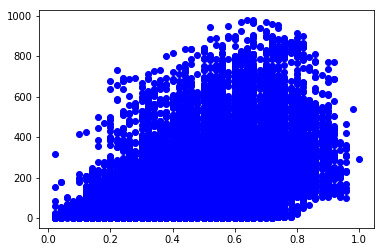

In [9]:
# create a plot of temp vs. cnt
print(plt.plot(pandas_df['temp'],pandas_df['cnt'],'bo')) 

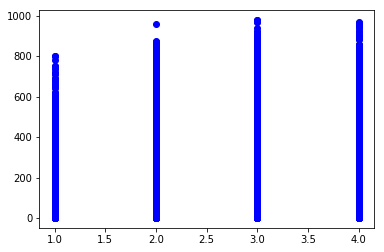

In [10]:
# create a plot of season vs. cnt
plt.plot(pandas_df['season'],pandas_df['cnt'],'bo') 

(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

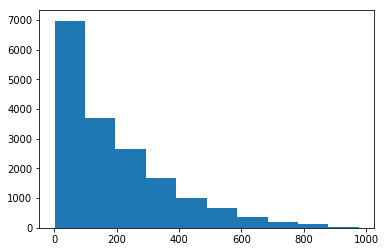

In [11]:
# Histogram of 'cnt'
plt.hist(pandas_df['cnt']) 
#plt.hist(pandas_df['casual'])
#plt.hist(pandas_df['registered'])
#plt.hist(pandas_df['temp'])
#plt.hist(pandas_df['hum'])

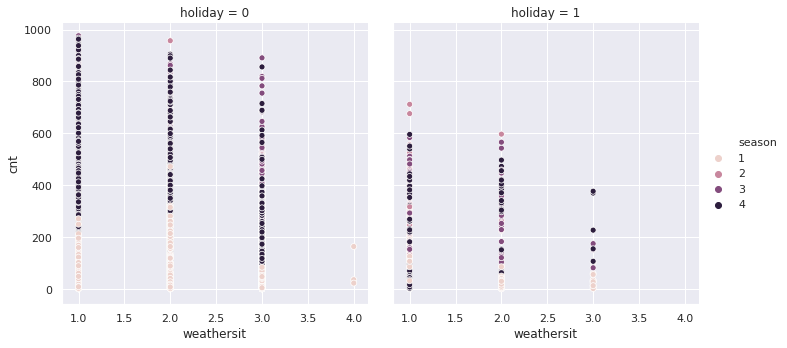

In [12]:
#seaborn.replot: provides access to several different axes-level functions that show the relationship between two variables with semantic mappings of subset 
sns.set(style='whitegrid',color_codes=True)
sns.set(rc={'figure.figsize':(11.7,9.27)})
sns.relplot(x="weathersit", y="cnt", col="holiday", hue='season', data=pandas_df)


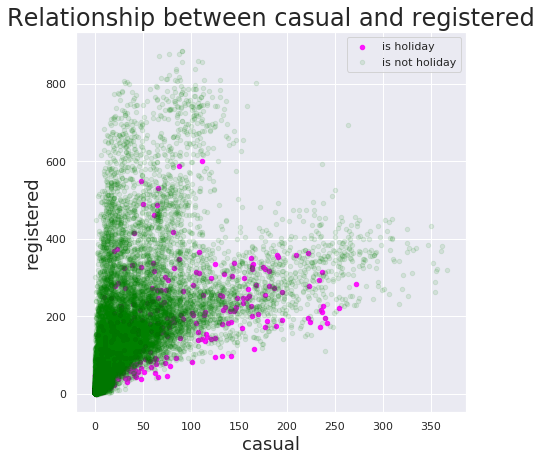

In [13]:
#scatter plot
ax1 = pandas_df[pandas_df['holiday'] == 1].plot(kind='scatter', x='casual', y='registered', color='magenta', alpha=0.9, figsize=(7, 7))
pandas_df[pandas_df['holiday'] == 0].plot(kind='scatter', x='casual', y='registered', color='green', alpha=0.1, figsize=(7 ,7), ax=ax1)
plt.legend(labels=['is holiday', 'is not holiday'])
plt.title('Relationship between casual and registered', size=24)
plt.xlabel('casual', size=18)
plt.ylabel('registered', size=18);

In [14]:
# 2.4 data quality check .1
df2.count()

17379

In [15]:
# drop null value
df2.na.drop().count()

17379

In [16]:
# 2.4 data quality check .2
m_check = pd.isnull(pandas_df)# creating m_value True for NaN values 
pandas_df[m_check] 

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# 3  Preparing Data for Machine Learning
# Mock-steps
# split dataset
mock_df1 = df2.select('instant','dteday','season','yr','mnth','hr','casual','registered','cnt')
mock_df2 = df2.select('instant','holiday','weekday','workingday')
mock_df3 = df2.select('instant','weathersit','temp','atemp','hum','windspeed')
# merge the dataset
mock_df4 = mock_df1.join(mock_df2, on=['instant'], how='outer')
mock_df5 = mock_df3.join(mock_df4, on=['instant'], how='outer')
print((mock_df5.count(), len(mock_df5.columns)))
mock_df5.printSchema()


(17379, 17)
root
 |-- instant: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: float (nullable = true)
 |-- atemp: float (nullable = true)
 |-- hum: float (nullable = true)
 |-- windspeed: float (nullable = true)
 |-- dteday: string (nullable = true)
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- hr: integer (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- cnt: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- workingday: integer (nullable = true)



In [18]:
# 4.1 reduce data check 
# 4.1.1 drop the irrelevant attribute, i.e. 'instant','dteday'

pandas_df.drop(['instant','dteday'],axis=1,inplace=True) #drop two columns
print((pandas_df.count(), len(pandas_df.columns)))

(season        17379
yr            17379
mnth          17379
hr            17379
holiday       17379
weekday       17379
workingday    17379
weathersit    17379
temp          17379
atemp         17379
hum           17379
windspeed     17379
casual        17379
registered    17379
cnt           17379
dtype: int64, 15)


In [19]:
# 4.1.2 visualize the outliers and extremes
###caution: I use '#' to hide the following code becasue it could take a bit time to run.

#sb.pairplot(pandas_df)

In [20]:
# 4.1.3.1 Removing outliers and extremes use The interquartile range (IQR) 
Q1 = pandas_df.quantile(0.05)
Q3 = pandas_df.quantile(0.95)
IQR = Q3 - Q1
print(IQR)

pandas_df_remove = pandas_df[~((pandas_df < (Q1 - 1.5 * IQR)) |(pandas_df > (Q3 + 1.5 * IQR))).any(axis=1)]
print(pandas_df_remove.shape)

season          3.0000
yr              1.0000
mnth           11.0000
hr             21.0000
holiday         0.0000
weekday         6.0000
workingday      1.0000
weathersit      2.0000
temp            0.6000
atemp           0.5303
hum             0.6200
windspeed       0.4179
casual        138.1000
registered    461.0000
cnt           558.1000
dtype: float64
(16869, 15)


In [21]:
# 4.1.3.2compare with initial dataset
print((df1.count(), len(df1.columns)))

(17379, 17)


In [22]:
# The Updated dateframe df3 at the end of step 4.1
df3 = spark.createDataFrame(pandas_df_remove)
df3 = df3.selectExpr("cast(season as int) season","cast(yr as int) yr", "cast(mnth as int) mnth", "cast(hr as int) hr", "cast(holiday as int) holiday",
                     "cast(weekday as int) weekday", "cast(workingday as int) workingday", "cast(weathersit as int) weathersit", 
                     "cast(temp as float) temp", "cast(atemp as float) atemp", "cast(hum as float) hum", "cast(windspeed as float) windspeed", 
                     "cast(casual as int) casual", "cast(registered as int) registered", "cast(cnt as int) cnt")
df3.printSchema()
df3.show()
print((df3.count(), len(df3.columns)))

root
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- hr: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: float (nullable = true)
 |-- atemp: float (nullable = true)
 |-- hum: float (nullable = true)
 |-- windspeed: float (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- cnt: integer (nullable = true)

+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+------+----------+---+
|season| yr|mnth| hr|holiday|weekday|workingday|weathersit|temp| atemp| hum|windspeed|casual|registered|cnt|
+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+------+----------+---+
|     1|  0|   1|  0|      0|      6|         0|         1|0.24|0.2879|0.81|      0.0|     3

In [23]:
# 4.2.1 Feature Selection - Numerical inputs and Numerical output - Pearson correlation coefficient
# 4.2.1.1 prepare for calcualtions of spearmanr_coefficient
cnt = pandas_df_remove['cnt']
temp = pandas_df_remove['temp']
atemp = pandas_df_remove['atemp']
hum = pandas_df_remove['hum']
windspeed = pandas_df_remove['windspeed']
casual = pandas_df_remove['casual']
registered = pandas_df_remove['registered']

In [24]:
# 4.2.1.2.1 calculate the coefficient
spearmanr_coefficient,p_value = spearmanr(cnt,temp)
print(spearmanr_coefficient)

0.4183387411422545


In [25]:
# 4.2.1.2.2 calculate the coefficient
spearmanr_coefficient,p_value = spearmanr(cnt,atemp)
print(spearmanr_coefficient)

0.41825554953978883


In [26]:
# 4.2.1.2.4 calculate the coefficient
spearmanr_coefficient,p_value = spearmanr(cnt,windspeed)
print(spearmanr_coefficient)

0.12812328854404365


In [27]:
# 4.2.1.2.5 calculate the coefficient
spearmanr_coefficient,p_value = spearmanr(cnt,casual)
print(spearmanr_coefficient)

0.8492610479837848


In [28]:
# 4.2.1.2.6 calculate the coefficient
spearmanr_coefficient,p_value = spearmanr(cnt,registered)
print(spearmanr_coefficient)

0.9897234464584578


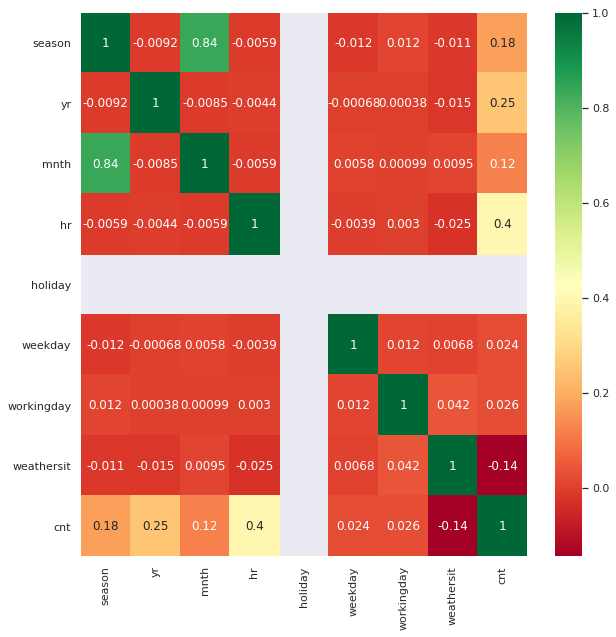

In [29]:
# 4.2.2 Feature selection - Relationship between Categorical inputs and numeric output
# 4.2.2.1 setting up
feature_selection_2 = df3.select("*").toPandas()
feature_selection_2.drop(['temp','atemp','hum','windspeed','casual','registered'],axis=1,inplace=True) 
# 4.2.2.2 plot heat map
corrmat = feature_selection_2.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
g=sns.heatmap(feature_selection_2[top_corr_features].corr(),annot=True,cmap="RdYlGn") #plot heat map

In [30]:
# 6.3.1 Build/Select appropriate model(s) and choose relevant parameter(s)
df4 = df3.select('season', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt')
cols = df4.columns,
df4.printSchema()
print((df4.count(), len(df4.columns)))

root
 |-- season: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: float (nullable = true)
 |-- atemp: float (nullable = true)
 |-- hum: float (nullable = true)
 |-- windspeed: float (nullable = true)
 |-- cnt: integer (nullable = true)

(16869, 7)


In [31]:
season_indexer = StringIndexer(inputCol='season',outputCol='season_index')
weathersit_indexer = StringIndexer(inputCol='weathersit',outputCol='weathersit_index')

season_encoder = OneHotEncoder(inputCol='season_index',outputCol='season',dropLast=False)
weathersit_encoder = OneHotEncoder(inputCol='weathersit_index', outputCol='weathersit',dropLast=False)

assembler = VectorAssembler(inputCols=['season',
        'weathersit','temp','atemp','hum','windspeed'], outputCol='features')

df5 = assembler.transform(df4)
df5 = df5.select('features','cnt')
df5.show()

+--------------------+---+
|            features|cnt|
+--------------------+---+
|[1.0,1.0,0.239999...| 16|
|[1.0,1.0,0.219999...| 40|
|[1.0,1.0,0.219999...| 32|
|[1.0,1.0,0.239999...| 13|
|[1.0,1.0,0.239999...|  1|
|[1.0,2.0,0.239999...|  1|
|[1.0,1.0,0.219999...|  2|
|[1.0,1.0,0.200000...|  3|
|[1.0,1.0,0.239999...|  8|
|[1.0,1.0,0.319999...| 14|
|[1.0,1.0,0.379999...| 36|
|[1.0,1.0,0.360000...| 56|
|[1.0,1.0,0.419999...| 84|
|[1.0,2.0,0.460000...| 94|
|[1.0,2.0,0.460000...|106|
|[1.0,2.0,0.439999...|110|
|[1.0,2.0,0.419999...| 93|
|[1.0,2.0,0.439999...| 67|
|[1.0,3.0,0.419999...| 35|
|[1.0,3.0,0.419999...| 37|
+--------------------+---+
only showing top 20 rows



In [32]:
# 7.1 Data mining
(train, test) = df5.randomSplit([.7, .3])

In [33]:
# 7.2.1 Linear regression
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='cnt', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [18.783024159668834,7.98977275857674,120.57325817925424,232.47842882902498,-306.99976652324347,42.92458697187309]
Intercept: 145.34272448726844


In [34]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 155.655748
r2: 0.263821


In [35]:
train.describe().show()

+-------+------------------+
|summary|               cnt|
+-------+------------------+
|  count|             11792|
|   mean|189.23261533242876|
| stddev| 181.4228329992857|
|    min|                 1|
|    max|               977|
+-------+------------------+



In [36]:
lr_predictions = lr_model.transform(test)
lr_predictions.select("prediction","cnt","features").show()
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="cnt",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+---+--------------------+
|        prediction|cnt|            features|
+------------------+---+--------------------+
| 53.54352373876563| 27|[1.0,1.0,0.019999...|
| 85.85414995086836|  1|[1.0,1.0,0.019999...|
|48.635010015480816| 15|[1.0,1.0,0.019999...|
|55.343488086510945| 84|[1.0,1.0,0.019999...|
| 57.69369876424629|  1|[1.0,1.0,0.039999...|
| 58.64152520546287|180|[1.0,1.0,0.039999...|
| 58.21862062117084|177|[1.0,1.0,0.039999...|
| 65.86598686013059| 64|[1.0,1.0,0.059999...|
| 94.89675028515771|  3|[1.0,1.0,0.079999...|
|48.511172845891934|  1|[1.0,1.0,0.079999...|
| 20.37395946276112|  4|[1.0,1.0,0.079999...|
| 76.90235213802866| 11|[1.0,1.0,0.100000...|
| 78.51300224841587|  4|[1.0,1.0,0.100000...|
| 68.02385628913748|  3|[1.0,1.0,0.100000...|
| 67.04866021010899|  1|[1.0,1.0,0.100000...|
| 67.04866021010899| 10|[1.0,1.0,0.100000...|
| 107.9297037115003| 68|[1.0,1.0,0.100000...|
| 78.50888084701981| 33|[1.0,1.0,0.100000...|
| 76.89411020128617| 46|[1.0,1.0,0

In [37]:
test_result = lr_model.evaluate(test)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 157.035


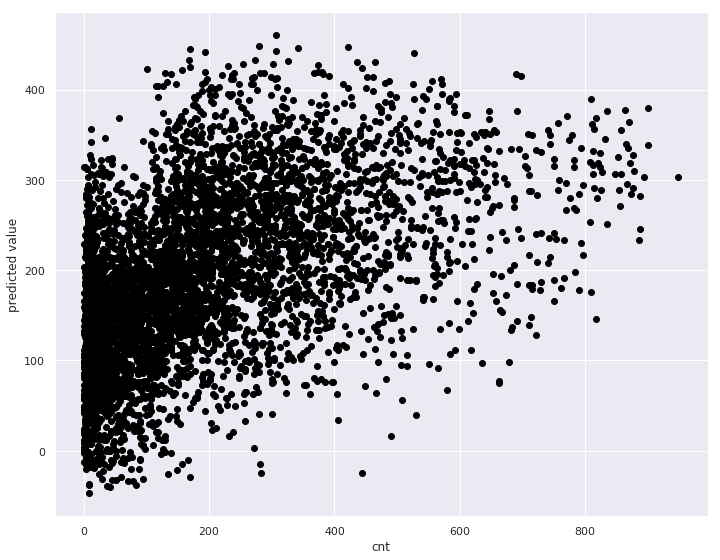

In [38]:
lr_pandas = lr_predictions.toPandas()

plt.plot(lr_pandas['cnt'],lr_pandas['prediction'],'o', color='black') 
plt.xlabel('cnt')
plt.ylabel('predicted value')
plt.show()

In [39]:
# 7.1.2 Regression trees
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'cnt')
dt_model = dt.fit(train)
dt_predictions = dt_model.transform(test)
dt_evaluator = RegressionEvaluator(
    labelCol="cnt", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 155.608


In [40]:
dt_model.featureImportances

SparseVector(6, {0: 0.0412, 1: 0.0076, 2: 0.1736, 3: 0.4592, 4: 0.3101, 5: 0.0083})

In [41]:
dt_predictions.select("prediction","cnt","features").show(20)

+----------------+---+--------------------+
|      prediction|cnt|            features|
+----------------+---+--------------------+
|65.3447251114413| 27|[1.0,1.0,0.019999...|
|65.3447251114413|  1|[1.0,1.0,0.019999...|
|65.3447251114413| 15|[1.0,1.0,0.019999...|
|65.3447251114413| 84|[1.0,1.0,0.019999...|
|65.3447251114413|  1|[1.0,1.0,0.039999...|
|65.3447251114413|180|[1.0,1.0,0.039999...|
|65.3447251114413|177|[1.0,1.0,0.039999...|
|65.3447251114413| 64|[1.0,1.0,0.059999...|
|65.3447251114413|  3|[1.0,1.0,0.079999...|
|65.3447251114413|  1|[1.0,1.0,0.079999...|
|65.3447251114413|  4|[1.0,1.0,0.079999...|
|65.3447251114413| 11|[1.0,1.0,0.100000...|
|65.3447251114413|  4|[1.0,1.0,0.100000...|
|65.3447251114413|  3|[1.0,1.0,0.100000...|
|65.3447251114413|  1|[1.0,1.0,0.100000...|
|65.3447251114413| 10|[1.0,1.0,0.100000...|
|65.3447251114413| 68|[1.0,1.0,0.100000...|
|65.3447251114413| 33|[1.0,1.0,0.100000...|
|65.3447251114413| 46|[1.0,1.0,0.100000...|
|65.3447251114413| 17|[1.0,1.0,0

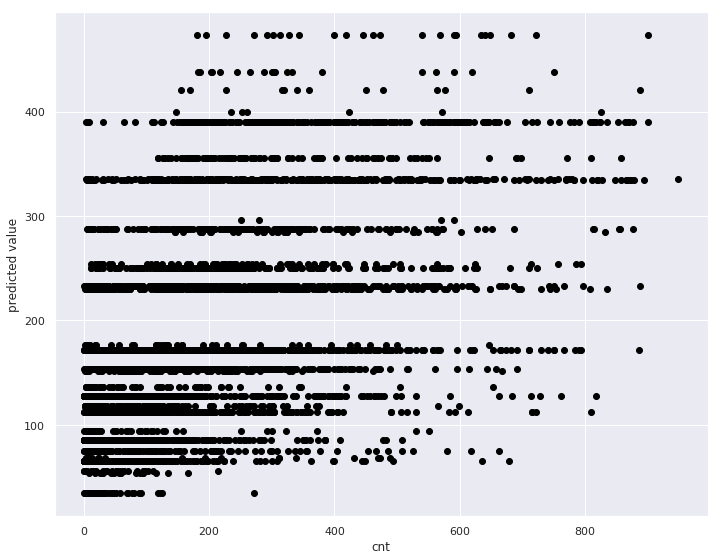

In [42]:
dt_pandas = dt_predictions.toPandas()
plt.plot(dt_pandas['cnt'],dt_pandas['prediction'],'o', color='black') 
plt.xlabel('cnt')
plt.ylabel('predicted value')
plt.show()